# PINN

In [1]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
torch.manual_seed(1234)
np.random.seed(1234)
import time
# 定义神经网络模型
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)


# 真解函数
def true_solution(x, t):
    return 2 / np.cosh(2 * x - 8 * t)

# 生成训练数据
def generate_training_data(L, T, N_in, N_i0, N_bc):
    # 内部点
    X_in = L * (2 * lhs(2, N_in) - 1)
    X_in[:, 1] *= T  # 时间范围 [0, T]
    
    # 初始条件（t=0）
    X_ic = L * (2 * lhs(1, N_ic) - 1)
    X_ic = np.hstack((X_ic, np.zeros((N_ic, 1))))  # 时间固定为0
    u_ic = true_solution(X_ic[:, 0], X_ic[:, 1])
    
    # 边界条件（x=±L）
    X_bc = T * lhs(1, N_bc)  # 时间采样
    X_bc = np.vstack((
        np.hstack((-L * np.ones((N_bc//2, 1)), X_bc[:N_bc//2])),  # x=-L
        np.hstack((L * np.ones((N_bc//2, 1)), X_bc[N_bc//2:]))    # x=L
    ))
    u_bc = true_solution(X_bc[:, 0], X_bc[:, 1])  # 计算边界真解
    
    # 转换为Tensor
    X_in = torch.tensor(X_in, dtype=torch.float32, requires_grad=True)
    X_ic = torch.tensor(X_ic, dtype=torch.float32)
    X_bc = torch.tensor(X_bc, dtype=torch.float32)
    u_ic = torch.tensor(u_ic, dtype=torch.float32).reshape(-1, 1)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).reshape(-1, 1)
    
    return X_in, X_ic, u_ic, X_bc, u_bc

# 物理信息损失计算
def physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc):
    def get_residual(X):
        X.requires_grad_(True)
        u = model(X)
        u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
        u_t = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
        u_xx = torch.autograd.grad(u_x, X, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_xxx = torch.autograd.grad(u_xx, X, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0][:, 0:1]
        residual = u_t + u_xxx + 6 * u**2 * u_x
        return residual
    residual_in = get_residual(X_in)
    loss_eq = torch.mean(residual_in**2)

    # 初始条件损失
    u_ic_pred = model(X_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # 边界条件损失（使用真解值）
    u_bc_pred = model(X_bc)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 总损失（加权）
    loss = loss_eq + loss_ic + loss_bc
    return loss, loss_eq, loss_ic + loss_bc
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")

# 运行训练
if __name__ == "__main__":
    layers = [2, 30,30,30, 1]  # 网络结构
    model = PINN(layers)   
    L = 3.0       # 空间域半长
    T = 2.0       # 时间域长度
    N_in = 700   # 内部点数量
    N_ic = 300    # 初始条件点数量
    N_bc = 300    # 边界条件点数量
    
    weight_history = {name: [] for name, _ in model.named_parameters()}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
   
    X_in, X_ic, u_ic, X_bc, u_bc = generate_training_data(L, T, N_in, N_ic, N_bc)
    start_time = time.time() 
    for epoch in range(20001):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        optimizer.step()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")
    end_time = time.time()  # 训练结束计时
    elapsed = end_time - start_time
    print(f"⏱  训练总耗时: {elapsed:.2f} 秒")     
# 生成测试数据
def generate_test_data():
    x = np.linspace(-3, 3, 100)
    t = np.linspace(0, 2, 100)
    X, T = np.meshgrid(x, t)
    X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_test = torch.tensor(X_test, dtype=torch.float32)
    u_test = true_solution(X_test[:, 0:1].detach().numpy(), X_test[:, 1:2].detach().numpy())
    u_test = torch.tensor(u_test, dtype=torch.float32)
    return X_test, X, T, u_test

# 假设模型已经定义并训练过，生成测试数据
X_test, X, T, u_test = generate_test_data()

# 获取预测值
u_pred = model(X_test).detach().numpy().reshape(X.shape)
u_true = u_test.detach().numpy().reshape(X.shape)
error = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)

print(f"L2 Relative Error: {error.item():.6f}")

Epoch     0, Loss: 8.1399e-01, Loss_eq: 5.0683e-04, Loss_ib: 8.1348e-01
Epoch  1000, Loss: 1.6629e-03, Loss_eq: 9.6410e-04, Loss_ib: 6.9878e-04
Epoch  2000, Loss: 5.6386e-04, Loss_eq: 3.5776e-04, Loss_ib: 2.0610e-04
Epoch  3000, Loss: 2.7753e-04, Loss_eq: 1.9832e-04, Loss_ib: 7.9210e-05
Epoch  4000, Loss: 1.7525e-04, Loss_eq: 1.2856e-04, Loss_ib: 4.6685e-05
Epoch  5000, Loss: 1.2530e-04, Loss_eq: 9.2006e-05, Loss_ib: 3.3295e-05
Epoch  6000, Loss: 6.0959e-04, Loss_eq: 5.7260e-04, Loss_ib: 3.6989e-05
Epoch  7000, Loss: 1.8878e-04, Loss_eq: 1.7069e-04, Loss_ib: 1.8096e-05
Epoch  8000, Loss: 6.3620e-05, Loss_eq: 4.8881e-05, Loss_ib: 1.4739e-05
Epoch  9000, Loss: 7.4264e-04, Loss_eq: 7.1305e-04, Loss_ib: 2.9591e-05
Epoch 10000, Loss: 5.7239e-05, Loss_eq: 4.7885e-05, Loss_ib: 9.3538e-06
Epoch 11000, Loss: 6.9763e-05, Loss_eq: 6.0129e-05, Loss_ib: 9.6342e-06
Epoch 12000, Loss: 3.4102e-05, Loss_eq: 2.6497e-05, Loss_ib: 7.6047e-06
Epoch 13000, Loss: 3.3578e-05, Loss_eq: 2.6111e-05, Loss_ib: 7.4

# SPF-PINN-1

In [3]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
torch.manual_seed(1234)
np.random.seed(1234)
# 定义神经网络模型
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)


# 真解函数
def true_solution(x, t):
    return 2 / np.cosh(2 * x - 8 * t)

# 生成训练数据
def generate_training_data(L, T, N_in, N_i0, N_bc):
    # 内部点
    X_in = L * (2 * lhs(2, N_in) - 1)
    X_in[:, 1] *= T  # 时间范围 [0, T]
    
    # 初始条件（t=0）
    X_ic = L * (2 * lhs(1, N_ic) - 1)
    X_ic = np.hstack((X_ic, np.zeros((N_ic, 1))))  # 时间固定为0
    u_ic = true_solution(X_ic[:, 0], X_ic[:, 1])
    
    # 边界条件（x=±L）
    X_bc = T * lhs(1, N_bc)  # 时间采样
    X_bc = np.vstack((
        np.hstack((-L * np.ones((N_bc//2, 1)), X_bc[:N_bc//2])),  # x=-L
        np.hstack((L * np.ones((N_bc//2, 1)), X_bc[N_bc//2:]))    # x=L
    ))
    u_bc = true_solution(X_bc[:, 0], X_bc[:, 1])  # 计算边界真解
    
    # 转换为Tensor
    X_in = torch.tensor(X_in, dtype=torch.float32, requires_grad=True)
    X_ic = torch.tensor(X_ic, dtype=torch.float32)
    X_bc = torch.tensor(X_bc, dtype=torch.float32)
    u_ic = torch.tensor(u_ic, dtype=torch.float32).reshape(-1, 1)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).reshape(-1, 1)
    
    return X_in, X_ic, u_ic, X_bc, u_bc

# 物理信息损失计算
def physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc):
    def get_residual(X):
        X.requires_grad_(True)
        u = model(X)
        u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
        u_t = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
        u_xx = torch.autograd.grad(u_x, X, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_xxx = torch.autograd.grad(u_xx, X, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0][:, 0:1]
        residual = u_t + u_xxx + 6 * u**2 * u_x
        return residual
    residual_in = get_residual(X_in)
    loss_eq = torch.mean(residual_in**2)

    # 初始条件损失
    u_ic_pred = model(X_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # 边界条件损失（使用真解值）
    u_bc_pred = model(X_bc)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 总损失（加权）
    loss = loss_eq + loss_ic + loss_bc
    return loss, loss_eq, loss_ic + loss_bc
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):  
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")

# 运行训练
if __name__ == "__main__":
    
    L = 3.0       # 空间域半长
    T = 2.0       # 时间域长度
#     c = 4.0       # 波速参数
    N_in = 700   # 内部点数量
    N_ic = 300    # 初始条件点数量
    N_bc = 300    # 边界条件点数量
    l2_errors=[]
    num_1=[5000]  
    total_steps=20000
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3]
    start_time = time.time() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(len(num_1)):
        layers = [2, 30, 30, 30, 1]  # 网络结构
        model = PINN(layers)   
        weight_history = {name: [] for name, _ in model.named_parameters()}
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        X_in, X_ic, u_ic, X_bc, u_bc = generate_training_data(L, T, N_in, N_ic, N_bc)
        
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
            loss.backward()
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")

         
        #######################################
        n, m = num_1[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs = total_steps - num_1[i]
        train_with_mask(masks, optimizer, epochs)
        end_time = time.time()  # 训练结束计时
        elapsed = end_time - start_time
        print(f"⏱  训练总耗时: {elapsed:.2f} 秒") 

        def generate_test_data():
            x = np.linspace(-3, 3, 100)
            t = np.linspace(0, 2, 100)
            X, T = np.meshgrid(x, t)
            X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
            X_test = torch.tensor(X_test, dtype=torch.float32)
            u_test = true_solution(X_test[:, 0:1].detach().numpy(), X_test[:, 1:2].detach().numpy())
            u_test = torch.tensor(u_test, dtype=torch.float32)
            return X_test, X, T, u_test

        # 假设模型已经定义并训练过，生成测试数据
        X_test, X, T, u_test = generate_test_data()

        # 获取预测值
        u_pred = model(X_test).detach().numpy().reshape(X.shape)
        u_true = u_test.detach().numpy().reshape(X.shape)
        error = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
        l2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")

Epoch     0, Loss: 8.1399e-01, Loss_eq: 5.0683e-04, Loss_ib: 8.1348e-01
Epoch  1000, Loss: 1.6629e-03, Loss_eq: 9.6410e-04, Loss_ib: 6.9878e-04
Epoch  2000, Loss: 5.6386e-04, Loss_eq: 3.5776e-04, Loss_ib: 2.0610e-04
Epoch  3000, Loss: 2.7753e-04, Loss_eq: 1.9832e-04, Loss_ib: 7.9210e-05
Epoch  4000, Loss: 1.7525e-04, Loss_eq: 1.2856e-04, Loss_ib: 4.6685e-05
掩码中值为 0 的元素个数： {'net.linear_0.weight': 24, 'net.linear_0.bias': 15, 'net.linear_1.weight': 459, 'net.linear_1.bias': 16, 'net.linear_2.weight': 385, 'net.linear_2.bias': 22, 'net.linear_3.weight': 13, 'net.linear_3.bias': 1}
掩码中值为 0 的元素个数之和 935
Epoch     0, Loss: 1.2530e-04, Loss_eq: 9.2006e-05, Loss_ib: 3.3295e-05
Epoch  1000, Loss: 8.8454e-05, Loss_eq: 6.8624e-05, Loss_ib: 1.9829e-05
Epoch  2000, Loss: 6.3208e-05, Loss_eq: 4.8898e-05, Loss_ib: 1.4310e-05
Epoch  3000, Loss: 3.2085e-04, Loss_eq: 2.9321e-04, Loss_ib: 2.7636e-05
Epoch  4000, Loss: 3.6924e-05, Loss_eq: 2.7650e-05, Loss_ib: 9.2743e-06
Epoch  5000, Loss: 3.0443e-05, Loss

# SPF-PINN-4

In [4]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
torch.manual_seed(1234)
np.random.seed(1234)
# 定义神经网络模型
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)


# 真解函数
def true_solution(x, t):
    return 2 / np.cosh(2 * x - 8 * t)

# 生成训练数据
def generate_training_data(L, T, N_in, N_i0, N_bc):
    # 内部点
    X_in = L * (2 * lhs(2, N_in) - 1)
    X_in[:, 1] *= T  # 时间范围 [0, T]
    
    # 初始条件（t=0）
    X_ic = L * (2 * lhs(1, N_ic) - 1)
    X_ic = np.hstack((X_ic, np.zeros((N_ic, 1))))  # 时间固定为0
    u_ic = true_solution(X_ic[:, 0], X_ic[:, 1])
    
    # 边界条件（x=±L）
    X_bc = T * lhs(1, N_bc)  # 时间采样
    X_bc = np.vstack((
        np.hstack((-L * np.ones((N_bc//2, 1)), X_bc[:N_bc//2])),  # x=-L
        np.hstack((L * np.ones((N_bc//2, 1)), X_bc[N_bc//2:]))    # x=L
    ))
    u_bc = true_solution(X_bc[:, 0], X_bc[:, 1])  # 计算边界真解
    
    # 转换为Tensor
    X_in = torch.tensor(X_in, dtype=torch.float32, requires_grad=True)
    X_ic = torch.tensor(X_ic, dtype=torch.float32)
    X_bc = torch.tensor(X_bc, dtype=torch.float32)
    u_ic = torch.tensor(u_ic, dtype=torch.float32).reshape(-1, 1)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).reshape(-1, 1)
    
    return X_in, X_ic, u_ic, X_bc, u_bc

# 物理信息损失计算
def physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc):
    def get_residual(X):
        X.requires_grad_(True)
        u = model(X)
        u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
        u_t = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
        u_xx = torch.autograd.grad(u_x, X, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_xxx = torch.autograd.grad(u_xx, X, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0][:, 0:1]
        residual = u_t + u_xxx + 6 * u**2 * u_x
        return residual
    residual_in = get_residual(X_in)
    loss_eq = torch.mean(residual_in**2)

    # 初始条件损失
    u_ic_pred = model(X_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # 边界条件损失（使用真解值）
    u_bc_pred = model(X_bc)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 总损失（加权）
    loss = loss_eq + loss_ic + loss_bc
    return loss, loss_eq, loss_ic + loss_bc
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):  
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")

# 运行训练
if __name__ == "__main__":
    
    L = 3.0       # 空间域半长
    T = 2.0       # 时间域长度
#     c = 4.0       # 波速参数
    N_in = 700   # 内部点数量
    N_ic = 300    # 初始条件点数量
    N_bc = 300    # 边界条件点数量
    l2_errors=[]
    num_1=[5000] 
    num_2=[10000] 
    num_3=[15000] 
    num_4=[18000] 
    total_steps=20000
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3]
    start_time = time.time() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(len(num_1)):
        layers = [2, 30,30,30, 1]  # 网络结构
        model = PINN(layers)   
        weight_history = {name: [] for name, _ in model.named_parameters()}
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        X_in, X_ic, u_ic, X_bc, u_bc = generate_training_data(L, T, N_in, N_ic, N_bc)
        
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
            loss.backward()
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")

         
        #######################################
        n, m = num_1[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs = num_2[i] - num_1[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_2[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =num_3[i]- num_2[i]
        train_with_mask(masks, optimizer,epochs)

        n, m = num_3[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =num_4[i]- num_3[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_4[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =total_steps - num_4[i]
        train_with_mask(masks, optimizer, epochs)
        end_time = time.time()  # 训练结束计时
        elapsed = end_time - start_time
        print(f"⏱  训练总耗时: {elapsed:.2f} 秒") 

        def generate_test_data():
            x = np.linspace(-3, 3, 100)
            t = np.linspace(0, 2, 100)
            X, T = np.meshgrid(x, t)
            X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
            X_test = torch.tensor(X_test, dtype=torch.float32)
            u_test = true_solution(X_test[:, 0:1].detach().numpy(), X_test[:, 1:2].detach().numpy())
            u_test = torch.tensor(u_test, dtype=torch.float32)
            return X_test, X, T, u_test

        # 假设模型已经定义并训练过，生成测试数据
        X_test, X, T, u_test = generate_test_data()

        # 获取预测值
        u_pred = model(X_test).detach().numpy().reshape(X.shape)
        u_true = u_test.detach().numpy().reshape(X.shape)
        error = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
        l2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")

Epoch     0, Loss: 8.1399e-01, Loss_eq: 5.0683e-04, Loss_ib: 8.1348e-01
Epoch  1000, Loss: 1.6629e-03, Loss_eq: 9.6410e-04, Loss_ib: 6.9878e-04
Epoch  2000, Loss: 5.6386e-04, Loss_eq: 3.5776e-04, Loss_ib: 2.0610e-04
Epoch  3000, Loss: 2.7753e-04, Loss_eq: 1.9832e-04, Loss_ib: 7.9210e-05
Epoch  4000, Loss: 1.7525e-04, Loss_eq: 1.2856e-04, Loss_ib: 4.6685e-05
掩码中值为 0 的元素个数： {'net.linear_0.weight': 24, 'net.linear_0.bias': 15, 'net.linear_1.weight': 459, 'net.linear_1.bias': 16, 'net.linear_2.weight': 385, 'net.linear_2.bias': 22, 'net.linear_3.weight': 13, 'net.linear_3.bias': 1}
掩码中值为 0 的元素个数之和 935
Epoch     0, Loss: 1.2530e-04, Loss_eq: 9.2006e-05, Loss_ib: 3.3295e-05
Epoch  1000, Loss: 8.8454e-05, Loss_eq: 6.8624e-05, Loss_ib: 1.9829e-05
Epoch  2000, Loss: 6.3208e-05, Loss_eq: 4.8898e-05, Loss_ib: 1.4310e-05
Epoch  3000, Loss: 3.2085e-04, Loss_eq: 2.9321e-04, Loss_ib: 2.7636e-05
Epoch  4000, Loss: 3.6924e-05, Loss_eq: 2.7650e-05, Loss_ib: 9.2743e-06
掩码中值为 0 的元素个数： {'net.linear_0.weigh

# PINN+NTK

In [91]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
torch.manual_seed(7000)
np.random.seed(7000)
# 定义神经网络模型
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)


# 真解函数
def true_solution(x, t):
    return 2 / np.cosh(2 * x - 8 * t)

# 生成训练数据
def generate_training_data(L, T, N_in, N_i0, N_bc):
    # 内部点
    X_in = L * (2 * lhs(2, N_in) - 1)
    X_in[:, 1] *= T  # 时间范围 [0, T]
    
    # 初始条件（t=0）
    X_ic = L * (2 * lhs(1, N_ic) - 1)
    X_ic = np.hstack((X_ic, np.zeros((N_ic, 1))))  # 时间固定为0
    u_ic = true_solution(X_ic[:, 0], X_ic[:, 1])
    
    # 边界条件（x=±L）
    X_bc = T * lhs(1, N_bc)  # 时间采样
    X_bc = np.vstack((
        np.hstack((-L * np.ones((N_bc//2, 1)), X_bc[:N_bc//2])),  # x=-L
        np.hstack((L * np.ones((N_bc//2, 1)), X_bc[N_bc//2:]))    # x=L
    ))
    u_bc = true_solution(X_bc[:, 0], X_bc[:, 1])  # 计算边界真解
    
    # 转换为Tensor
    X_in = torch.tensor(X_in, dtype=torch.float32, requires_grad=True)
    X_ic = torch.tensor(X_ic, dtype=torch.float32)
    X_bc = torch.tensor(X_bc, dtype=torch.float32)
    u_ic = torch.tensor(u_ic, dtype=torch.float32).reshape(-1, 1)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).reshape(-1, 1)
    
    return X_in, X_ic, u_ic, X_bc, u_bc

# 物理信息损失计算
def physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc):
    def get_residual(X):
        X.requires_grad_(True)
        u = model(X)
        u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
        u_t = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
        u_xx = torch.autograd.grad(u_x, X, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_xxx = torch.autograd.grad(u_xx, X, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0][:, 0:1]
        residual = u_t + u_xxx + 6 * u**2 * u_x
        return residual
    residual_in = get_residual(X_in)
    loss_eq = torch.mean(residual_in**2)

    # 初始条件损失
    u_ic_pred = model(X_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # 边界条件损失（使用真解值）
    u_bc_pred = model(X_bc)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 总损失（加权）
    loss = loss_eq + loss_ic + loss_bc
    return loss, loss_eq, loss_ic + loss_bc
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")
################################################################################################################
def compute_pde_jacobian(model, X, create_graph=True):
    """计算mKdV方程PDE残差的雅可比矩阵"""
    X = X.clone().detach().requires_grad_(True)

    # 前向传播获取预测值
    u = model(X)
    
    # 计算一阶导数 u_x, u_t
    grad_u = torch.autograd.grad(u.sum(), X, create_graph=create_graph)[0]
    u_x = grad_u[:, 0:1]  # 空间导数
    u_t = grad_u[:, 1:2]  # 时间导数
    
    # 计算二阶导数 u_xx（用于后续三阶导数）
    grad_u_x = torch.autograd.grad(u_x.sum(), X, create_graph=create_graph)[0]
    u_xx = grad_u_x[:, 0:1]
    
    # 计算三阶导数 u_xxx（mKdV方程核心项）
    grad_u_xx = torch.autograd.grad(u_xx.sum(), X, create_graph=create_graph)[0]
    u_xxx = grad_u_xx[:, 0:1]
    
    # mKdV方程残差: u_t + 6*u^2*u_x + u_xxx
    f = u_t + 6 * (u**2) * u_x + u_xxx  # 主要修改点：非线性项系数调整

    # 计算残差对参数的雅可比矩阵（与原代码结构相同）
    jacobian_list = []
    for i in range(f.size(0)):
        grad_outputs = torch.ones_like(f[i])
        grads = torch.autograd.grad(
            outputs=f[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=create_graph,
            retain_graph=True,
            allow_unused=True
        )
        
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                      for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.reshape(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_jacobian_pinn(model, X_u, create_graph=True):
    """初边值条件的雅可比矩阵（保持结构不变）"""
    X_u = X_u.clone().detach().requires_grad_(True)
    
    u = model(X_u[:, :2])  # 输入保持(x,t)结构
    
    jacobian_list = []
    for i in range(u.size(0)):
        grad_outputs = torch.ones_like(u[i])
        grads = torch.autograd.grad(
            outputs=u[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=create_graph,
            retain_graph=True,
            allow_unused=True
        )
        
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                      for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.reshape(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_all_eigenvalues(K_uu, K_rr, K):
    """特征值计算函数（保持结构不变）"""
    K_uu = K_uu.float()
    K_rr = K_rr.float()
    K = K.float()
    
    eig_uu = torch.linalg.eigvalsh(K_uu)
    eig_rr = torch.linalg.eigvalsh(K_rr)
    eig_k = torch.linalg.eigvalsh(K)
    
    eigenvalues_uu = torch.sort(eig_uu, descending=True)[0].numpy()
    eigenvalues_rr = torch.sort(eig_rr, descending=True)[0].numpy()
    eigenvalues_k = torch.sort(eig_k, descending=True)[0].numpy()
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k
# 运行训练
if __name__ == "__main__":
    layers = [2, 100,100, 1]  # 网络结构
    model1 = PINN(layers)   
    L = 3.0       # 空间域半长
    T = 2.0       # 时间域长度
#     c = 4.0       # 波速参数
    N_in = 700   # 内部点数量
    N_ic = 300    # 初始条件点数量
    N_bc = 300    # 边界条件点数量
    eigenvalues_uu_history = []
    eigenvalues_rr_history = []
    eigenvalues_k_history = []
    weight_history = {name: [] for name, _ in model1.named_parameters()}
    optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
   
    X_in, X_ic, u_ic, X_bc, u_bc = generate_training_data(L, T, N_in, N_ic, N_bc)
    for epoch in range(20001):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model1, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        optimizer.step()
        for name, param in model1.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")
        if epoch % 500 == 0 and epoch > 0:
            print("\n--- NTK特征值分析开始 ---")
            X_ib = torch.cat([X_ic, X_bc], dim=0)
            J_u = compute_jacobian_pinn(model1, X_ib, create_graph=False)  # 只传入 x 和 y 部分
            #J_r = compute_pde_jacobian(model, X_in, create_graph=False)
            J_r = compute_pde_jacobian(model1, X_in)

            # 计算 NTK 子矩阵
            K_uu = torch.mm(J_u, J_u.t()).detach()
            K_ur = torch.mm(J_u, J_r.t()).detach()
            K_ru = torch.mm(J_r, J_u.t()).detach()
            K_rr = torch.mm(J_r, J_r.t()).detach()
            K = torch.vstack([
            torch.hstack([K_uu, K_ur]),
            torch.hstack([K_ru, K_rr])
            ])
            print(f"K_uu shape: {K_uu.shape}")
            print(f"K_ur shape: {K_ur.shape}")
            print(f"K_ru shape: {K_ru.shape}")
            print(f"K_rr shape: {K_rr.shape}")
            print(f"K shape: {K.shape}")
            eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
            eigenvalues_uu_history.append(eigenvalues_uu)
            eigenvalues_rr_history.append(eigenvalues_rr)
            eigenvalues_k_history.append(eigenvalues_k)
# 生成测试数据
def generate_test_data():
    x = np.linspace(-3, 3, 100)
    t = np.linspace(0, 2, 100)
    X, T = np.meshgrid(x, t)
    X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    X_test = torch.tensor(X_test, dtype=torch.float32)
    u_test = true_solution(X_test[:, 0:1].detach().numpy(), X_test[:, 1:2].detach().numpy())
    u_test = torch.tensor(u_test, dtype=torch.float32)
    return X_test, X, T, u_test

# 假设模型已经定义并训练过，生成测试数据
X_test, X, T, u_test = generate_test_data()

# 获取预测值
u_pred = model1(X_test).detach().numpy().reshape(X.shape)
u_true = u_test.detach().numpy().reshape(X.shape)
error = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)

print(f"L2 Relative Error: {error.item():.6f}")

Epoch     0, Loss: 7.9676e-01, Loss_eq: 4.3188e-03, Loss_ib: 7.9245e-01

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  1000, Loss: 1.6943e-03, Loss_eq: 8.5400e-04, Loss_ib: 8.4025e-04

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  2000, Loss: 3.3968e-04, Loss_eq: 1.8807e-04, Loss_ib: 1.5161e-04

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK


--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch 19000, Loss: 3.7019e-04, Loss_eq: 3.2716e-04, Loss_ib: 4.3025e-05

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch 20000, Loss: 1.8813e-05, Loss_eq: 4.6522e-06, Loss_ib: 1.4160e-05

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
L2 Relative Error: 0.125146


# SPF-PINN+NTK

In [89]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs
torch.manual_seed(7000)
np.random.seed(7000)
# 定义神经网络模型
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            if i != len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)


# 真解函数
def true_solution(x, t):
    return 2 / np.cosh(2 * x - 8 * t)

# 生成训练数据
def generate_training_data(L, T, N_in, N_i0, N_bc):
    # 内部点
    X_in = L * (2 * lhs(2, N_in) - 1)
    X_in[:, 1] *= T  # 时间范围 [0, T]
    
    # 初始条件（t=0）
    X_ic = L * (2 * lhs(1, N_ic) - 1)
    X_ic = np.hstack((X_ic, np.zeros((N_ic, 1))))  # 时间固定为0
    u_ic = true_solution(X_ic[:, 0], X_ic[:, 1])
    
    # 边界条件（x=±L）
    X_bc = T * lhs(1, N_bc)  # 时间采样
    X_bc = np.vstack((
        np.hstack((-L * np.ones((N_bc//2, 1)), X_bc[:N_bc//2])),  # x=-L
        np.hstack((L * np.ones((N_bc//2, 1)), X_bc[N_bc//2:]))    # x=L
    ))
    u_bc = true_solution(X_bc[:, 0], X_bc[:, 1])  # 计算边界真解
    
    # 转换为Tensor
    X_in = torch.tensor(X_in, dtype=torch.float32, requires_grad=True)
    X_ic = torch.tensor(X_ic, dtype=torch.float32)
    X_bc = torch.tensor(X_bc, dtype=torch.float32)
    u_ic = torch.tensor(u_ic, dtype=torch.float32).reshape(-1, 1)
    u_bc = torch.tensor(u_bc, dtype=torch.float32).reshape(-1, 1)
    
    return X_in, X_ic, u_ic, X_bc, u_bc

# 物理信息损失计算
def physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc):
    def get_residual(X):
        X.requires_grad_(True)
        u = model(X)
        u_x = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
        u_t = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
        u_xx = torch.autograd.grad(u_x, X, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_xxx = torch.autograd.grad(u_xx, X, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0][:, 0:1]
        residual = u_t + u_xxx + 6 * u**2 * u_x
        return residual
    residual_in = get_residual(X_in)
    loss_eq = torch.mean(residual_in**2)

    # 初始条件损失
    u_ic_pred = model(X_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)

    # 边界条件损失（使用真解值）
    u_bc_pred = model(X_bc)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 总损失（加权）
    loss = loss_eq + loss_ic + loss_bc
    return loss, loss_eq, loss_ic + loss_bc
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")
        if epoch % 500 == 0 and epoch > 0:
                print("\n--- NTK特征值分析开始 ---")
                X_ib = torch.cat([X_ic, X_bc], dim=0)
                J_u = compute_jacobian_pinn(model, X_ib, create_graph=False)  # 只传入 x 和 y 部分
                #J_r = compute_pde_jacobian(model, X_in, create_graph=False)
                J_r = compute_pde_jacobian(model, X_in)

                # 计算 NTK 子矩阵
                K_uu = torch.mm(J_u, J_u.t()).detach()
                K_ur = torch.mm(J_u, J_r.t()).detach()
                K_ru = torch.mm(J_r, J_u.t()).detach()
                K_rr = torch.mm(J_r, J_r.t()).detach()
                K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
                ])
                print(f"K_uu shape: {K_uu.shape}")
                print(f"K_ur shape: {K_ur.shape}")
                print(f"K_ru shape: {K_ru.shape}")
                print(f"K_rr shape: {K_rr.shape}")
                print(f"K shape: {K.shape}")
                eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
                eigenvalues_uu_history1.append(eigenvalues_uu)
                eigenvalues_rr_history1.append(eigenvalues_rr)
                eigenvalues_k_history1.append(eigenvalues_k)
################################################################################################################
def compute_pde_jacobian(model, X, create_graph=True):
    """计算mKdV方程PDE残差的雅可比矩阵"""
    X = X.clone().detach().requires_grad_(True)

    # 前向传播获取预测值
    u = model(X)
    
    # 计算一阶导数 u_x, u_t
    grad_u = torch.autograd.grad(u.sum(), X, create_graph=create_graph)[0]
    u_x = grad_u[:, 0:1]  # 空间导数
    u_t = grad_u[:, 1:2]  # 时间导数
    
    # 计算二阶导数 u_xx（用于后续三阶导数）
    grad_u_x = torch.autograd.grad(u_x.sum(), X, create_graph=create_graph)[0]
    u_xx = grad_u_x[:, 0:1]
    
    # 计算三阶导数 u_xxx（mKdV方程核心项）
    grad_u_xx = torch.autograd.grad(u_xx.sum(), X, create_graph=create_graph)[0]
    u_xxx = grad_u_xx[:, 0:1]
    
    f = u_t + 6 * (u**2) * u_x + u_xxx  

    # 计算残差对参数的雅可比矩阵（与原代码结构相同）
    jacobian_list = []
    for i in range(f.size(0)):
        grad_outputs = torch.ones_like(f[i])
        grads = torch.autograd.grad(
            outputs=f[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=create_graph,
            retain_graph=True,
            allow_unused=True
        )
        
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                      for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.reshape(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_jacobian_pinn(model, X_u, create_graph=True):
    """初边值条件的雅可比矩阵（保持结构不变）"""
    X_u = X_u.clone().detach().requires_grad_(True)
    
    u = model(X_u[:, :2])  # 输入保持(x,t)结构
    
    jacobian_list = []
    for i in range(u.size(0)):
        grad_outputs = torch.ones_like(u[i])
        grads = torch.autograd.grad(
            outputs=u[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=create_graph,
            retain_graph=True,
            allow_unused=True
        )
        
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                      for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.reshape(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_all_eigenvalues(K_uu, K_rr, K):
    """特征值计算函数（保持结构不变）"""
    K_uu = K_uu.float()
    K_rr = K_rr.float()
    K = K.float()
    
    eig_uu = torch.linalg.eigvalsh(K_uu)
    eig_rr = torch.linalg.eigvalsh(K_rr)
    eig_k = torch.linalg.eigvalsh(K)
    
    eigenvalues_uu = torch.sort(eig_uu, descending=True)[0].numpy()
    eigenvalues_rr = torch.sort(eig_rr, descending=True)[0].numpy()
    eigenvalues_k = torch.sort(eig_k, descending=True)[0].numpy()
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k
# 运行训练
if __name__ == "__main__":
    
    L = 3.0       # 空间域半长
    T = 2.0       # 时间域长度
#     c = 4.0       # 波速参数
    N_in = 700   # 内部点数量
    N_ic = 300    # 初始条件点数量
    N_bc = 300    # 边界条件点数量
    l2_errors=[]
    num_1=[4000] 
    num_2=[10000] 
    num_3=[15000]  
    num_4=[18000]  
    eigenvalues_uu_history1 = []
    eigenvalues_rr_history1 = []
    eigenvalues_k_history1 = []
    total_steps=20001
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3]
    for i in range(len(num_1)):
        layers = [2, 100,100, 1]  # 网络结构
        model = PINN(layers)   
        weight_history = {name: [] for name, _ in model.named_parameters()}
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        X_in, X_ic, u_ic, X_bc, u_bc = generate_training_data(L, T, N_in, N_ic, N_bc)
        
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            loss, loss_eq, loss_ib = physics_loss(model, X_in, X_ic, u_ic, X_bc, u_bc)
            loss.backward()
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d}, Loss: {loss.item():.4e}, Loss_eq: {loss_eq.item():.4e}, Loss_ib: {loss_ib.item():.4e}")
            if epoch % 500 == 0 and epoch > 0:
                print("\n--- NTK特征值分析开始 ---")
                X_ib = torch.cat([X_ic, X_bc], dim=0)
                J_u = compute_jacobian_pinn(model, X_ib, create_graph=False)  # 只传入 x 和 y 部分
                #J_r = compute_pde_jacobian(model, X_in, create_graph=False)
                J_r = compute_pde_jacobian(model, X_in)

                # 计算 NTK 子矩阵
                K_uu = torch.mm(J_u, J_u.t()).detach()
                K_ur = torch.mm(J_u, J_r.t()).detach()
                K_ru = torch.mm(J_r, J_u.t()).detach()
                K_rr = torch.mm(J_r, J_r.t()).detach()
                K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
                ])
                print(f"K_uu shape: {K_uu.shape}")
                print(f"K_ur shape: {K_ur.shape}")
                print(f"K_ru shape: {K_ru.shape}")
                print(f"K_rr shape: {K_rr.shape}")
                print(f"K shape: {K.shape}")
                eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
                eigenvalues_uu_history1.append(eigenvalues_uu)
                eigenvalues_rr_history1.append(eigenvalues_rr)
                eigenvalues_k_history1.append(eigenvalues_k)


         
        #######################################
        n, m = num_1[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs = num_2[i] - num_1[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_2[i]-1000,1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =num_3[i]- num_2[i]
        train_with_mask(masks, optimizer,epochs)

        n, m = num_3[i]-1000,1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =total_steps- num_3[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_4[i]-1000,1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =total_steps - num_4[i]
        train_with_mask(masks, optimizer, epochs)
        

        # 生成测试数据
        def generate_test_data():
            x = np.linspace(-3,3, 100)
            t = np.linspace(0, 2, 100)
            X, T = np.meshgrid(x, t)
            X_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
            X_test = torch.tensor(X_test, dtype=torch.float32)
            u_test = true_solution(X_test[:, 0:1].detach().numpy(), X_test[:, 1:2].detach().numpy())
            u_test = torch.tensor(u_test, dtype=torch.float32)
            return X_test, X, T, u_test

        # 假设模型已经定义并训练过，生成测试数据
        X_test, X, T, u_test = generate_test_data()

        # 获取预测值
        u_pred = model(X_test).detach().numpy().reshape(X.shape)
        u_true = u_test.detach().numpy().reshape(X.shape)
        error = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
        l2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")

Epoch     0, Loss: 7.9676e-01, Loss_eq: 4.3188e-03, Loss_ib: 7.9245e-01

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  1000, Loss: 1.6943e-03, Loss_eq: 8.5400e-04, Loss_ib: 8.4025e-04

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  2000, Loss: 3.3968e-04, Loss_eq: 1.8807e-04, Loss_ib: 1.5161e-04

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK


--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  4000, Loss: 1.2070e-05, Loss_eq: 6.7422e-06, Loss_ib: 5.3281e-06

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
Epoch  5000, Loss: 5.7561e-06, Loss_eq: 1.2849e-06, Loss_ib: 4.4713e-06

--- NTK特征值分析开始 ---
K_uu shape: torch.Size([600, 600])
K_ur shape: torch.Size([600, 700])
K_ru shape: torch.Size([700, 600])
K_rr shape: torch.Size([700, 700])
K shape: torch.Size([1300, 1300])
L2 Relative Error: 0.063383


# NTK-comparision

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


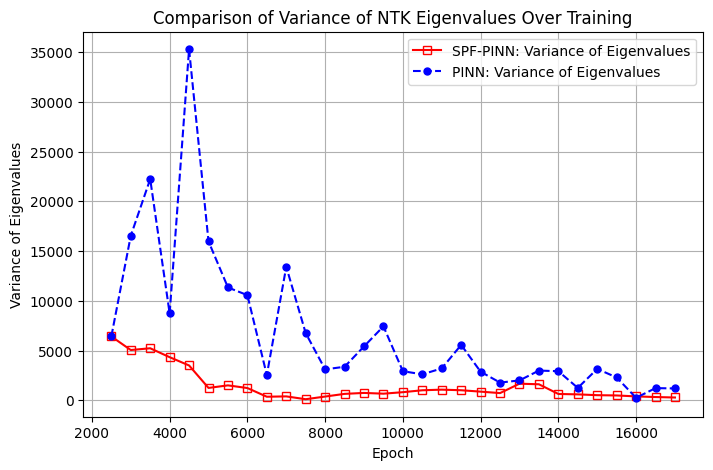

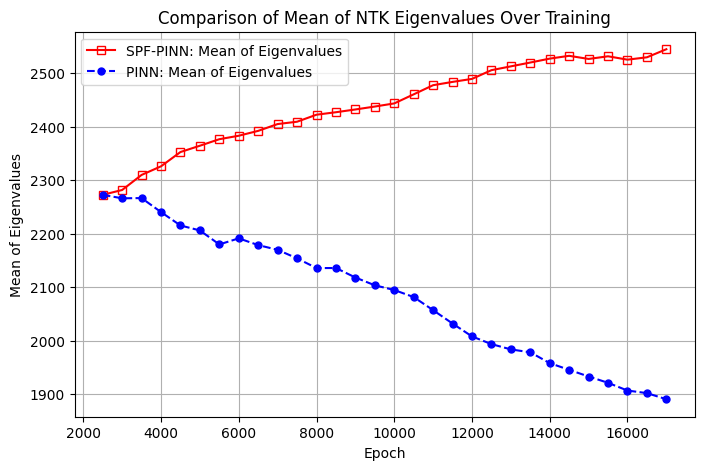

In [92]:
import numpy as np
import os
import matplotlib.pyplot as plt

# 参数设置
start_epoch =2500
step_interval = 3 # 每隔 4 轮计算一次
interval = 500  # 训练步长，影响 epoch 计算

# 转换为 NumPy 数组
eigenvalues_k_history_1 = np.array(eigenvalues_k_history1)
eigenvalues_k_history_0 = np.array(eigenvalues_k_history)
# 找到最小长度
min_len = min(len(eigenvalues_k_history_1), len(eigenvalues_k_history_0))

# 截取两个数组，使它们的长度一致
eigenvalues_k_history_1 = eigenvalues_k_history_1[:min_len]
eigenvalues_k_history_0 = eigenvalues_k_history_0[:min_len]
# 计算数量信息eigenvalues_k_history
num_snapshots1 = len(eigenvalues_k_history_1)
num_snapshots2 = len(eigenvalues_k_history_0)
assert num_snapshots1 == num_snapshots2, "两组特征值历史长度不匹配"

# 存储计算结果
var_over_time1, mean_over_time1, var_over_time2, mean_over_time2 = [], [], [], []
epochs = []

# 计算滑动窗口的方差和均值
for i in range(num_snapshots1 - step_interval):
    epoch = (i + 1) * interval
    if epoch >= start_epoch:
        # 计算第一组
        eigenvalues_segment1 = eigenvalues_k_history_1[i : i + step_interval]
        filterd_eigenval=eigenvalues_segment1
        #eigenvar1 = np.var(eigenvalues_segment1, axis=0)
        eigenvar1 = np.var(filterd_eigenval, axis=0)
        eigenmean1 = np.mean(eigenvalues_segment1, axis=0)
        valid_indices1 = eigenmean1 >= 1e-3
        filtered_eigenmean1 = eigenmean1[valid_indices1]

        # 计算第二组
        eigenvalues_segment2 = eigenvalues_k_history_0[i : i + step_interval]
        filterd_eigenval2=eigenvalues_segment2
        eigenvar2 = np.var(filterd_eigenval2, axis=0)
        #eigenvar2 = np.var(eigenvalues_segment2, axis=0)
        eigenmean2 = np.mean(eigenvalues_segment2, axis=0)
        valid_indices2 = eigenmean2 >= 1e-3
        filtered_eigenmean2 = eigenmean2[valid_indices2]

        # 计算整体均值和方差
        var_over_time1.append(np.mean(eigenvar1))
        mean_over_time1.append(np.mean(filtered_eigenmean1) if len(filtered_eigenmean1) > 0 else 0)

        var_over_time2.append(np.mean(eigenvar2))
        mean_over_time2.append(np.mean(filtered_eigenmean2) if len(filtered_eigenmean2) > 0 else 0)

        epochs.append(epoch)

# **第一张图：方差随 Epoch 变化**
plt.figure(figsize=(8, 5))
plt.plot(epochs, var_over_time1, marker='s', linestyle='-', color='r',  markerfacecolor='none',label="SPF-PINN: Variance of Eigenvalues")
plt.plot(epochs, var_over_time2, marker='o', linestyle='--', color='b',markersize=5,label="PINN: Variance of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Variance of Eigenvalues")
plt.title("Comparison of Variance of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)
plt.show()

# **第二张图：均值随 Epoch 变化**
plt.figure(figsize=(8, 5))
plt.plot(epochs, mean_over_time1, marker='s', linestyle='-', color='r',  markerfacecolor='none',label="SPF-PINN: Mean of Eigenvalues")
plt.plot(epochs, mean_over_time2, marker='o', linestyle='--', color='b', 
         markersize=5, label="PINN: Mean of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Mean of Eigenvalues")
plt.title("Comparison of Mean of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)
plt.show()
